# Synapse Labeling

In [1]:
import datajoint as dj
import numpy as np
from scipy.spatial import KDTree
import time
from tqdm import tqdm
import ipyvolume.pylab as p3

In [2]:
from label_ops import LabelOps

In [108]:
dj.config['display.limit'] = 20
ta3p100 = dj.create_virtual_module('ta3p100', 'microns_ta3p100')

In [4]:
schema = dj.schema('microns_ta3p100')

@schema
class SynapseCompartmentLabel(dj.Computed):
    definition = """
    -> ta3p100.Synapse
    ---
    (postsynaptic_label)->ta3p100.LabelKey
    """ # (postsynaptic_label)->ta3p100.LabelKey : tinyint unsigned

In [5]:
segment_ids = ta3p100.CoarseLabel.fetch('segment_id')
mesh_fetch = (ta3p100.CleansedMesh & ta3p100.Compartment.proj()).fetch()
label_fetch = ta3p100.CoarseLabel.fetch()

meshes = dict()
labels = dict()
for segment in tqdm(mesh_fetch):
    meshes[segment[1]] = (segment[5], segment[6])
    
for segment in tqdm(label_fetch):
    labels[segment[1]] = (segment[6], segment[7])
    
kdtrees = dict()
for segment_id in tqdm(segment_ids):
    kdtrees[segment_id] = KDTree(meshes[segment_id][0])
    
mesh_synapses = dict()
for segment_id in tqdm(segment_ids):
    mesh_synapses[segment_id] = np.array((ta3p100.Synapse & ta3p100.CurrentSegmentation
                                          & dict(presyn=segment_id)).fetch('synapse_id', 'presyn_x', 'presyn__y', 'presyn__z')).T
#                                           & dict(postsyn=segment_id)).fetch('synapse_id', 'postsyn_x', 'postsyn_y', 'postsyn_z')).T

100%|██████████| 319/319 [02:38<00:00,  1.96it/s]


In [6]:
# segment_ids = ta3.CorrectedLabel().fetch('segment_id')
# labels = dict()
# for segment_id in tqdm(segment_ids):
#     labels[segment_id] = (ta3.CorrectedLabel & dict(segment_id=segment_id)).fetch1('vertices', 'triangles')

# meshes = dict()
# kdtrees = dict()
# for segment_id in tqdm(segment_ids):
#     meshes[segment_id] = (ta3.Decimation & 'decimation_ratio=0.35' & dict(segment_id=segment_id)).fetch1('vertices', 'triangles')
#     kdtrees[segment_id] = KDTree(meshes[segment_id][0])

# mesh_synapses = dict()
# for segment_id in tqdm(segment_ids):
#     mesh_synapses[segment_id] = np.array((ta3.Synapse & dict(postsyn=segment_id)).fetch('synapse_id', 'synapse_x', 'synapse_y', 'synapse_z')).T

In [7]:
matched_synapses = dict()
for segment_id in tqdm(segment_ids):
    synapses = mesh_synapses[segment_id]
    synapse_ids, postsyn_coords = synapses.T[0], synapses.T[1:].T
    kdtree = kdtrees[segment_id]
    distances, nearest_nodes = kdtree.query(postsyn_coords * [4, 4, 40])
    vertex_labels = labels[segment_id][0]
    synapse_labels = dict()
    for synapse_id, nearest_node in zip(synapse_ids, nearest_nodes):
        synapse_labels[synapse_id] = vertex_labels[nearest_node]
    matched_synapses[segment_id] = synapse_labels

100%|██████████| 319/319 [03:36<00:00,  1.36it/s]


In [74]:
segmentation = ta3p100.CurrentSegmentation.fetch1('segmentation')
all_synapse_labels = list()
for labeled_synapses in tqdm(matched_synapses.values()):
    segmentation_array = np.array([segmentation] * len(labeled_synapses))
    synapse_to_label = np.array(list(labeled_synapses.items())).T
    proper_label_array = np.array((segmentation_array, *synapse_to_label)).T
    all_synapse_labels.extend(proper_label_array)
all_synapse_labels_array = np.array(all_synapse_labels)

all_synapse_labels_array.T[2][all_synapse_labels_array.T[2]>12] = 1

start = time.time()
SynapseCompartmentLabel.insert(all_synapse_labels_array, skip_duplicates=True)
print(time.time() - start)


100%|██████████| 319/319 [00:00<00:00, 944.11it/s]

70.07369637489319


In [75]:
print(len(SynapseCompartmentLabel() & 'segmentation=2'))
SynapseCompartmentLabel() & 'segmentation=2'

658818


segmentation segmentation id,synapse_id synapse index within the segmentation,postsynaptic_label numeric label of the compartment
2,1,3
2,2,4
2,5,3
2,25,4
2,30,2
2,36,4
2,40,2
2,41,3
2,69,3
2,72,5


# Spine Synapse Labeler

In [79]:
@schema
class SynapseSpineLabel(dj.Computed):
    definition = """
    # Denotes which synapses are also on Spine Heads, Spines, or Spine Necks
    -> ta3p100.SynapseCompartmentLabel
    ---
    (spine_label)->ta3p100.LabelKey
    """ # (spine_label)->ta3p100.LabelKey : tinyint unsigned

In [87]:
mesh_fetch = np.array((ta3p100.CleansedMesh & ta3p100.Compartment.proj()).fetch('segment_id', 'vertices', 'triangles')).T
label_fetch = np.array(ta3p100.OverlayedSpineLabel.fetch('segment_id', 'vertices', 'triangles')).T

meshes = dict()
for segment_id, mesh_vertices, mesh_triangles in tqdm(mesh_fetch):
    meshes[segment_id] = (mesh_vertices, mesh_triangles)

labels = dict()
for segment_id, label_vertices, label_triangles in tqdm(label_fetch):
    labels[segment_id] = (label_vertices, label_triangles)
    
kdtrees = dict()
for segment_id in tqdm(segment_ids):
    kdtrees[segment_id] = KDTree(meshes[segment_id][0])
    
mesh_synapses = dict()
for segment_id in tqdm(segment_ids):
    mesh_synapses[segment_id] = np.array((ta3p100.Synapse & ta3p100.CurrentSegmentation
                                          & dict(postsyn=segment_id)).fetch('synapse_id', 'postsyn_x','postsyn_y', 'postsyn_z')).T


 97%|█████████▋| 309/319 [02:21<00:04,  2.41it/s]


100%|██████████| 319/319 [02:26<00:00,  2.33it/s]


In [ ]:
#mesh_synapses = dict()
#for segment_id in tqdm(segment_ids):
#    mesh_synapses[segment_id] = np.array((ta3.Synapse & 'segmentation=1'
#                                          & dict(postsyn=segment_id)).fetch('synapse_id', 'synapse_x',
#                                                                            'synapse_y', 'synapse_z')).T

In [88]:
matched_synapses = dict()
for segment_id in tqdm(segment_ids):
    synapses = mesh_synapses[segment_id]
    synapse_ids, postsyn_coords = synapses.T[0], synapses.T[1:].T
    kdtree = kdtrees[segment_id]
    distances, nearest_nodes = kdtree.query(postsyn_coords * [4, 4, 40])
    vertex_labels = labels[segment_id][0]
    synapse_labels = dict()
    for synapse_id, nearest_node in zip(synapse_ids, nearest_nodes):
        synapse_labels[synapse_id] = vertex_labels[nearest_node]
    matched_synapses[segment_id] = synapse_labels


100%|██████████| 319/319 [03:44<00:00,  1.28it/s]


In [89]:
segmentation = ta3p100.CurrentSegmentation.fetch1('segmentation')
all_synapse_labels = list()
for labeled_synapses in tqdm(matched_synapses.values()):
    segmentation_array = np.array([segmentation] * len(labeled_synapses))
    synapse_to_label = np.array(list(labeled_synapses.items())).T
    proper_label_array = np.array((segmentation_array, *synapse_to_label)).T
    all_synapse_labels.extend(proper_label_array)
all_synapse_labels_array = np.array(all_synapse_labels)

all_synapse_labels_array.T[2][all_synapse_labels_array.T[2]>15] = 1
all_synapse_labels_array = all_synapse_labels_array[all_synapse_labels_array.T[2]<=15]
all_synapse_labels_array = all_synapse_labels_array[all_synapse_labels_array.T[2]>12]

start = time.time()
SynapseSpineLabel.insert(all_synapse_labels_array, skip_duplicates=True)
print(time.time() - start)


100%|██████████| 319/319 [00:00<00:00, 922.49it/s]

43.53742527961731


In [90]:
SynapseSpineLabel & 'spine_label<13'

segmentation segmentation id,synapse_id synapse index within the segmentation,spine_label numeric label of the compartment


In [91]:
#(SynapseSpineLabel & 'spine_label<13').delete()

In [92]:
SynapseSpineLabel()

segmentation segmentation id,synapse_id synapse index within the segmentation,spine_label numeric label of the compartment
2,5,13
2,25,13
2,41,13
2,73,13
2,77,13
2,108,13
2,125,13
2,130,13
2,137,13
2,148,13


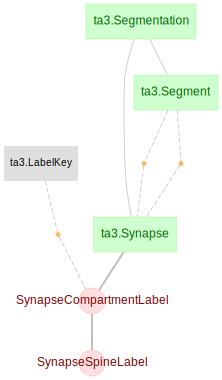

In [62]:
dj.ERD(SynapseSpineLabel) - 3

In [118]:
((ta3p100.ComponentLabel() & 'segmentation=2') - 'segment_id=648518346341366885') - 'segment_id=648518346341371119'

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,"compartment_type Basal, Apical, spine head, etc.",component_index Which sub-compartment of a certain label this is.,clusters what the clustering parameter was set to,"smoothness what the smoothness parameter was set to, number betwee 0 and 1",time_updated the time at which the component labels were updated,n_vertices number of vertices in component,n_triangles number of faces in component,"labeled_vertices indicate which vertices are spine,spine_head,spine_neck otherwise 0","labeled_triangles indicate which faces are spine,spine_head,spine_neck otherwise 0","n_heads totals the number of heads after classification, helps for optimization","used_version whether this component is used in the final labels or not, 0 no, 1 yes"
2,648518346341388820,0.35,Apical,0,12,0.04,2019-01-26 23:47:59,45391,90483,=BLOB=,=BLOB=,153,1
2,648518346341388820,0.35,Basal,0,12,0.04,2019-01-26 23:46:10,1782,3348,=BLOB=,=BLOB=,0,1
2,648518346341388820,0.35,Basal,1,12,0.04,2019-01-26 23:46:11,3508,6950,=BLOB=,=BLOB=,1,1
2,648518346341388820,0.35,Basal,2,12,0.04,2019-01-26 23:46:11,998,1932,=BLOB=,=BLOB=,0,1
2,648518346341388820,0.35,Oblique,0,12,0.04,2019-01-26 23:47:46,38547,76923,=BLOB=,=BLOB=,185,1
2,648518346341388820,0.35,Oblique,1,12,0.04,2019-01-26 23:46:11,2073,4105,=BLOB=,=BLOB=,0,1
2,648518346341393609,0.35,Apical,0,12,0.04,2019-01-26 23:46:15,9634,19035,=BLOB=,=BLOB=,2,1
2,648518346341393609,0.35,Basal,0,12,0.04,2019-01-26 23:46:36,29391,58504,=BLOB=,=BLOB=,100,1
2,648518346341393609,0.35,Basal,1,16,0.04,2019-01-27 00:03:38,162883,325149,=BLOB=,=BLOB=,837,1
2,648518346341393609,0.35,Basal,2,12,0.04,2019-01-26 23:46:12,2636,5212,=BLOB=,=BLOB=,1,1


## Visualization of Labeled Synapses (no labeled Spines yet)

In [109]:
ta3p100.LabelKey()

numeric numeric label of the compartment,description descriptive name of the label,color representative color of the compartment
0,not_labeled,no_color
1,label_removed,no_color
2,Apical,blue
3,Basal,yellow
4,Oblique,green
5,Soma,red
6,Axon-Soma,aqua
7,Axon-Dendr,off blue
8,Dendrite,purple
9,Distal,pink


In [121]:
ta3p100.ProofreadLabel & 'segment_id=648518346341393609'

segmentation segmentation id,segment_id segment id unique within each Segmentation,decimation_ratio,author_original name of last editor,author_proofreader name of last editor,date_time the last time it was edited,vertices label data for the vertices,triangles label data for the faces,edges label data for the edges,status the index of the status descriptor that can be references by the StatusKey
2,648518346341393609,0.35,computer_Auto,bcelii,2019-01-24 19:36:28,=BLOB=,=BLOB=,=BLOB=,complete


In [124]:
label_keys = [( 0, 'not_labeled', 'no_color'), ( 1, 'label_removed', 'no_color'),
               ( 2, 'Apical', 'ignore blue'), ( 3, 'Basal', 'ignore yellow'),
               ( 4, 'Oblique', 'ignore green'), ( 5, 'Soma', 'ignore red'),
               ( 6, 'Axon-Soma', 'ignore aqua'), ( 7, 'Axon-Dendr', 'ignore off blue'),
               ( 8, 'Dendrite', 'ignore purple'), ( 9, 'Distal', 'ignore pink'),
               (10, 'ignore Error', 'brown'), (11, 'Unlabelable', 'ignore tan'),
               (12, 'Cilia', 'ignore orange'), (13, 'Spine Head (unsure if correct label)', 'red'),
               (14, 'Spine (unsure if correct label)', 'blue'),
               (15, 'Spine Neck (unsure if correct label)', 'ignore green'),
               (16, 'Bouton (unsure if correct label)', 'ignore')]
segment_id = 648518346341393609
synapse_label_types = np.unique(list(matched_synapses[segment_id].values()))
label_matches = np.array(list(matched_synapses[segment_id].items())).T
synapses_by_compartment = dict()
synapse_centroids_by_compartment = dict()
for synapse_label_type in synapse_label_types:
    synapses_by_compartment[synapse_label_type] = label_matches[0][np.where(label_matches[1]==synapse_label_type)[0]]
    centroids = np.zeros((len(synapses_by_compartment[synapse_label_type]), 3), dtype=np.uint32)
    for i, specific_synapse in enumerate(synapses_by_compartment[synapse_label_type]):
        centroids[i] = mesh_synapses[segment_id].T[1:].T[mesh_synapses[segment_id].T[0]==specific_synapse]
    synapse_centroids_by_compartment[synapse_label_type] = centroids
p3.figure(width=1024, height=1024)
vertices, triangles = meshes[segment_id]
p3.plot_trisurf(*vertices.T/1000, triangles=triangles, color='black')
for label_type, label_name, label_color in label_keys:
    if label_type in synapse_label_types:
        print("{} -> {} : {}".format(label_type, label_name, label_color))
        p3.scatter(*(synapse_centroids_by_compartment[label_type] * [4, 4, 40]).T/1000, color=label_color, marker='sphere', size=0.1)
p3.squarelim()
p3.show()

2 -> Apical : ignore blue
3 -> Basal : ignore yellow
4 -> Oblique : ignore green
5 -> Soma : ignore red
6 -> Axon-Soma : ignore aqua
10 -> ignore Error : brown
13 -> Spine Head (unsure if correct label) : red
14 -> Spine (unsure if correct label) : blue
15 -> Spine Neck (unsure if correct label) : ignore green
